In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations for the training and testing data
transform = transforms.Compose([transforms.ToTensor()])

# Load the training and test datasets
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 26421880/26421880 [00:00<00:00, 115008153.80it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4165513.06it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 62390517.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8619671.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(self.conv2(x), 2)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and the optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.1151
Epoch [2/5], Loss: 0.2152
Epoch [3/5], Loss: 0.0298
Epoch [4/5], Loss: 0.1018
Epoch [5/5], Loss: 0.0985


In [4]:
import numpy as np

def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    image = image.clone().detach().requires_grad_(True)
    output = model(image).data.numpy().flatten()
    label = np.argmax(output)
    
    input_shape = image.shape
    pert_image = image.clone().detach()
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)
    
    loop_i = 0
    
    x = pert_image.clone().detach().requires_grad_(True)
    fs = model(x)
    
    k_i = label
    
    while k_i == label and loop_i < max_iter:
        pert = np.inf
        fs[0, label].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()
        
        for k in range(num_classes):
            if k == label:
                continue
            x.grad.data.zero_()
            fs[0, k].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()
            
            w_k = cur_grad - grad_orig
            f_k = (fs[0, k] - fs[0, label]).data.numpy()
            
            pert_k = abs(f_k) / np.linalg.norm(w_k.flatten())
            
            if pert_k < pert:
                pert = pert_k
                w = w_k
        
        r_i = (pert + 1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)
        
        pert_image = image + (1 + overshoot) * torch.from_numpy(r_tot)
        
        x = pert_image.clone().detach().requires_grad_(True)
        fs = model(x)
        k_i = np.argmax(fs.data.numpy().flatten())
        
        loop_i += 1
    
    r_tot = (1 + overshoot) * r_tot
    return r_tot, loop_i, label, k_i, pert_image


Accuracy of the model on the normal test data: 91.80%
Accuracy of the model on the DeepFool adversarial examples: 6.03%


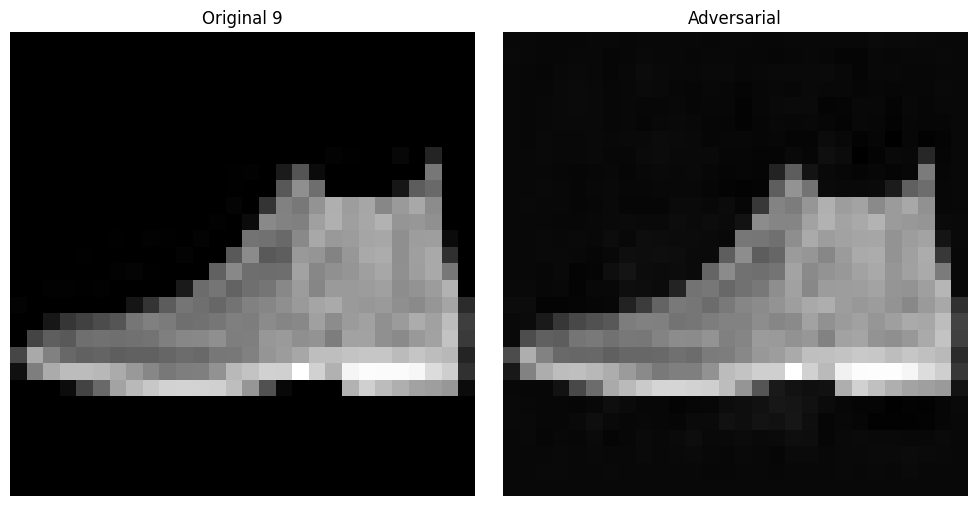

In [5]:
import matplotlib.pyplot as plt

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def evaluate_deepfool(model, data_loader, num_classes=10, overshoot=0.02, max_iter=50):
    correct = 0
    total = 0
    
    for images, labels in data_loader:
        images, labels = images.to('cpu'), labels.to('cpu')
        for i in range(images.size(0)):
            image = images[i].unsqueeze(0)
            r_tot, loop_i, label, k_i, pert_image = deepfool(image, model, num_classes, overshoot, max_iter)
            output = model(pert_image)
            _, predicted = torch.max(output.data, 1)
            total += 1
            correct += (predicted == labels[i]).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def visualize_deepfool(model, data_loader, num_classes=10, overshoot=0.02, max_iter=50):
    model.eval()
    images, labels = next(iter(data_loader))
    r_tot, loop_i, label, k_i, pert_image = deepfool(images[0].unsqueeze(0), model, num_classes, overshoot, max_iter)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(images[0].squeeze().numpy(), cmap='gray')
    axes[0].set_title(f"Original {labels[0].item()}")
    axes[0].axis('off')
    
    axes[1].imshow(pert_image.squeeze().detach().numpy(), cmap='gray')
    axes[1].set_title(f"Adversarial")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Evaluate and visualize the DeepFool attack
# Normal accuracy
normal_accuracy = evaluate(model, test_loader)
print(f'Accuracy of the model on the normal test data: {normal_accuracy:.2f}%')

# DeepFool accuracy
deepfool_accuracy = evaluate_deepfool(model, test_loader)
print(f'Accuracy of the model on the DeepFool adversarial examples: {deepfool_accuracy:.2f}%')

# Visualize original and adversarial images
visualize_deepfool(model, test_loader)
